# German Credit Scorecard Model

This project focuses on developing a credit scorecard model to assess an individual's creditworthiness based on financial features such as credit history, purpose, and savings. The model utilizes Weight of Evidence (WoE) and Information Value (IV) to transform categorical and numerical features into meaningful predictive variables, followed by logistic regression for credit risk assessment.

The scorecard is designed to provide an interpretable and data-driven approach to credit scoring, which can be used in financial lending and risk evaluation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, classification_report, 
                           confusion_matrix, RocCurveDisplay, f1_score,
                           average_precision_score, balanced_accuracy_score)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from scipy.stats import ks_2samp
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
colors = sns.color_palette('Set2')

## Data Preparation

Cleans and structures raw credit data for modeling.

In [2]:
class DataPreprocessor:
    """Handles all data loading and preprocessing"""
    
    def __init__(self):
        self.column_mapping = {
            'laufkont': 'Status',
            'laufzeit': 'Duration',
            'moral': 'Credit History',
            'verw': 'Purpose',
            'hoehe': 'Amount',
            'sparkont': 'Savings',
            'beszeit': 'Employment Duration',
            'rate': 'Installment Rate',
            'famges': 'Personal Status Sex',
            'buerge': 'Other Debtors',
            'wohnzeit': 'Present Residence',
            'verm': 'Property',
            'alter': 'Age',
            'weitkred': 'Other Installment Plans',
            'wohn': 'Housing',
            'bishkred': 'Number Credits',
            'beruf': 'Job',
            'pers': 'People Liable',
            'telef': 'Telephone',
            'gastarb': 'Foreign Worker',
            'kredit': 'Credit Risk'
        }
        
        self.nominal_cols = ['Credit History', 'Purpose', 'Personal Status Sex', 
                            'Other Debtors', 'Property', 'Other Installment Plans', 
                            'Housing', 'Job', 'Telephone', 'Foreign Worker']
        self.ordinal_cols = ['Status', 'Savings', 'Employment Duration', 
                           'Installment Rate', 'Present Residence', 
                           'Number Credits', 'People Liable']
        self.numerical_cols = ['Duration', 'Amount', 'Age']
    
    def load_and_preprocess(self, filepath):
        """Load and preprocess the raw data"""
        print("📊 Loading and Processing Dataset...")
        df = pd.read_csv(filepath)
        
        # Rename columns to English
        df.rename(columns=self.column_mapping, inplace=True)
        
        # Handle missing values
        print(f"🔍 Missing values before cleaning: {df.isnull().sum().sum()}")
        df = df.dropna()
        print(f"🔍 Missing values after cleaning: {df.isnull().sum().sum()}")
        
        return df

## Feature Engineering

Converts raw features into WoE values that quantify risk.

In [3]:
class WoEBinningTransformer(BaseEstimator, TransformerMixin):
    """Handles consistent WoE binning and transformation"""
    
    def __init__(self, n_bins=5):
        self.n_bins = n_bins
        self.bin_edges_ = {}
        self.woe_dict_ = {}
        self.iv_dict_ = {}
    
    def fit(self, X, y):
        """Calculate bins and WoE values from training data"""
        # Bin numerical features
        for col in [c for c in X.columns if c in ['Duration', 'Amount', 'Age']]:
            self.bin_edges_[col] = pd.qcut(X[col], q=self.n_bins, duplicates='drop', retbins=True)[1]
        
        # Calculate WoE/IV for all features
        for feature in X.columns:
            if feature in self.bin_edges_:
                binned_feature = pd.cut(X[feature], bins=self.bin_edges_[feature], include_lowest=True)
                crosstab, iv = self._calculate_woe_iv(pd.DataFrame({feature: binned_feature, 'target': y}), feature, 'target')
            else:
                crosstab, iv = self._calculate_woe_iv(pd.DataFrame({feature: X[feature], 'target': y}), feature, 'target')
            
            self.woe_dict_[feature] = crosstab
            self.iv_dict_[feature] = iv
        
        return self
    
    def transform(self, X):
        """Transform features to WoE values"""
        X_woe = pd.DataFrame(index=X.index)
        
        for feature in self.woe_dict_:
            if feature in self.bin_edges_:
                # Handle binned numerical features
                binned = pd.cut(X[feature], bins=self.bin_edges_[feature], include_lowest=True)
                # Convert intervals to strings for mapping
                binned_str = binned.astype(str)
                X_woe[feature] = binned_str.map(self.woe_dict_[feature]['woe'].to_dict())
            else:
                # Handle categorical features - ensure string type
                cat_series = X[feature].astype(str)
                X_woe[feature] = cat_series.map(self.woe_dict_[feature]['woe'].to_dict())
            
            # Handle unseen categories with mean WoE
            X_woe[feature].fillna(self.woe_dict_[feature]['woe'].mean(), inplace=True)
        
        return X_woe
    
    def _calculate_woe_iv(self, df, feature, target, epsilon=1e-6):
        """Calculate Weight of Evidence and Information Value"""
        # Ensure we're working with strings for categorical features
        if df[feature].dtype.name == 'category':
            df[feature] = df[feature].astype(str)
            
        crosstab = pd.crosstab(df[feature], df[target], margins=False)
        
        # Ensure we have both classes
        if 0 not in crosstab.columns:
            crosstab[0] = 0
        if 1 not in crosstab.columns:
            crosstab[1] = 0
            
        crosstab.columns = ['good', 'bad']
        crosstab['total'] = crosstab['good'] + crosstab['bad']
        crosstab['bad_rate'] = crosstab['bad'] / crosstab['total']
        
        # Calculate proportions
        crosstab['bad_pct'] = crosstab['bad'] / (crosstab['bad'].sum() + epsilon)
        crosstab['good_pct'] = crosstab['good'] / (crosstab['good'].sum() + epsilon)
        
        # Calculate WoE and IV
        crosstab['woe'] = np.log((crosstab['good_pct'] + epsilon) / (crosstab['bad_pct'] + epsilon))
        crosstab['iv_component'] = (crosstab['good_pct'] - crosstab['bad_pct']) * crosstab['woe']
        iv = crosstab['iv_component'].sum()
        
        return crosstab.sort_values('bad_rate'), iv


## Modeling Pipeline

 Ranks features by their predictive power (IV) and model weights.

In [4]:
class CreditScorecardModel:
    """End-to-end credit scorecard modeling"""
    
    def __init__(self, base_score=600, pdo=50, base_odds=50):
        self.base_score = base_score
        self.pdo = pdo
        self.base_odds = base_odds
        self.factor = pdo / np.log(2)
        self.offset = base_score - self.factor * np.log(base_odds)
        self.preprocessor = DataPreprocessor()
        self.woe_transformer = None
        self.model = None
    
    def load_data(self, filepath, test_size=0.2):
        """Load and split data"""
        df = self.preprocessor.load_and_preprocess(filepath)
        X = df.drop('Credit Risk', axis=1)
        y = df['Credit Risk']
        
        # Stratified train-test split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y)
        
        return self
    
    def train_model(self):
        """Train the scorecard model with proper validation"""
        # Set up pipeline with SMOTE for imbalance handling
        self.woe_transformer = WoEBinningTransformer()
        
        # Create the base classifier
        base_lr = LogisticRegression(
            class_weight='balanced', 
            penalty='l2',
            C=0.1,
            solver='liblinear',
            random_state=42
        )
        
        # Create pipeline
        pipeline = make_pipeline(
            self.woe_transformer,
            SMOTE(random_state=42, sampling_strategy=0.5),
            CalibratedClassifierCV(
                base_lr,
                cv=5,
                method='isotonic'
            )
        )
        
        # Train model
        print("\n🔄 Training Model with Cross-Validation...")
        self.model = pipeline.fit(self.X_train, self.y_train)
        
        # Get feature importance - updated for CalibratedClassifierCV
        calibrated_model = self.model.named_steps['calibratedclassifiercv']
        
        # For scikit-learn >= 1.2, use 'calibrated_classifiers_'
        if hasattr(calibrated_model, 'calibrated_classifiers_'):
            # Get the first classifier's coefficients (average would also work)
            coefs = calibrated_model.calibrated_classifiers_[0].estimator.coef_[0]
        else:
            # Fallback for older versions (though they should have 'estimators_')
            coefs = calibrated_model.estimators_[0].coef_[0]
        
        self.feature_importance = pd.DataFrame({
            'Feature': self.X_train.columns,
            'IV': list(self.woe_transformer.iv_dict_.values()),
            'Coefficient': coefs
        }).sort_values('IV', ascending=False)
        
        return self
    
    def evaluate(self):
        """Evaluate model performance"""
        print("\n📊 Model Evaluation:")
        
        # Get predictions
        train_probs = self.model.predict_proba(self.X_train)[:, 1]
        test_probs = self.model.predict_proba(self.X_test)[:, 1]
        
        # Find optimal threshold
        threshold = self._find_optimal_threshold(train_probs, self.y_train)
        y_pred = (test_probs >= threshold).astype(int)
        
        # Calculate metrics
        metrics = {
            'AUC-ROC': roc_auc_score(self.y_test, test_probs),
            'AUC-PR': average_precision_score(self.y_test, test_probs),
            'Balanced Accuracy': balanced_accuracy_score(self.y_test, y_pred),
            'KS Statistic': self._calculate_ks(self.y_test, test_probs)
        }
        
        print("\nPerformance Metrics:")
        for name, value in metrics.items():
            print(f"{name}: {value:.4f}")
        
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred, 
                                  target_names=['Good Credit', 'Bad Credit']))
        
        # Plot feature importance
        self._plot_feature_importance()
        
        return metrics
    
    def create_scorecard(self):
        """Generate the credit scorecard"""
        print("\n📝 Building Credit Scorecard...")
        
        # Get model components - updated for scikit-learn compatibility
        calibrated_model = self.model.named_steps['calibratedclassifiercv']
        
        # Handle both old and new scikit-learn versions
        if hasattr(calibrated_model, 'calibrated_classifiers_'):
            # New versions (scikit-learn >= 1.2)
            log_reg = calibrated_model.calibrated_classifiers_[0].estimator
        else:
            # Old versions (should have 'estimators_')
            log_reg = calibrated_model.estimators_[0]
        
        woe_dict = self.woe_transformer.woe_dict_
        
        # Calculate base points
        base_points = self.offset - self.factor * log_reg.intercept_[0]
        
        # Create scorecard
        scorecard = {}
        for i, feature in enumerate(self.feature_importance['Feature']):
            coef = log_reg.coef_[0][i]
            scorecard[feature] = {}
            
            for category, woe in woe_dict[feature]['woe'].items():
                points = -self.factor * coef * woe
                scorecard[feature][str(category)] = points
        
        # Calculate scores
        train_scores = self._calculate_scores(self.X_train, scorecard, base_points)
        test_scores = self._calculate_scores(self.X_test, scorecard, base_points)
        
        # Analyze score distribution
        self._analyze_scores(test_scores, self.y_test)
        
        return scorecard, base_points
    
    # ========== HELPER METHODS ==========
    def _find_optimal_threshold(self, probs, y_true):
        """Find optimal threshold using validation data"""
        # Use stratified CV to find threshold
        cv = StratifiedKFold(n_splits=5)
        y_preds = cross_val_predict(
            self.model.named_steps['calibratedclassifiercv'],
            self.woe_transformer.transform(self.X_train),
            self.y_train,
            cv=cv,
            method='predict_proba'
        )[:, 1]
        
        # Find threshold maximizing F1
        thresholds = np.linspace(0, 1, 100)
        f1_scores = []
        for t in thresholds:
            preds = (y_preds >= t).astype(int)
            f1 = f1_score(self.y_train, preds)
            f1_scores.append(f1)
        
        return thresholds[np.argmax(f1_scores)]
    
    def _calculate_ks(self, y_true, y_probs):
        """Calculate KS statistic"""
        goods = y_probs[y_true == 0]
        bads = y_probs[y_true == 1]
        ks_stat, _ = ks_2samp(goods, bads)
        return ks_stat * 100  # Return as percentage
    
    def _calculate_scores(self, X, scorecard, base_points):
        """Calculate credit scores for a dataset"""
        X_woe = self.woe_transformer.transform(X)
        scores = np.full(len(X), base_points)
        
        for feature in scorecard:
            for i, value in enumerate(X_woe[feature]):
                # Find closest matching category
                if str(value) in scorecard[feature]:
                    points = scorecard[feature][str(value)]
                else:
                    # Use average points for unseen categories
                    points = np.mean(list(scorecard[feature].values()))
                
                scores[i] += points
        
        return scores
    
    def _analyze_scores(self, scores, y_true):
        """Analyze score distribution and performance"""
        # Create score bands
        score_bands = pd.qcut(scores, q=10, duplicates='drop')
        
        # Calculate default rates by band
        band_stats = pd.DataFrame({
            'Score Band': score_bands,
            'Default': y_true
        }).groupby('Score Band').agg(
            Count=('Default', 'count'),
            Default_Rate=('Default', 'mean')
        ).sort_index(ascending=False)
        
        print("\nDefault Rates by Score Band:")
        print(band_stats)
        
        # Plot score distribution
        plt.figure(figsize=(12, 6))
        sns.histplot(
            x=scores,
            hue=y_true.map({0: 'Good', 1: 'Bad'}),
            multiple='stack',
            bins=20
        )
        plt.title('Credit Score Distribution by Risk Level')
        plt.xlabel('Credit Score')
        plt.ylabel('Count')
        plt.show()
    
    def _plot_feature_importance(self):
        """Plot feature importance by IV"""
        plt.figure(figsize=(12, 8))
        sns.barplot(
            data=self.feature_importance,
            x='IV',
            y='Feature',
            palette='viridis'
        )
        plt.title('Feature Importance by Information Value (IV)')
        plt.xlabel('Information Value')
        plt.axvline(x=0.02, color='red', linestyle='-', alpha=0.7, label='Weak')
        plt.axvline(x=0.1, color='orange', linestyle='-', alpha=0.7, label='Medium')
        plt.axvline(x=0.3, color='green', linestyle='-', alpha=0.7, label='Strong')
        plt.legend()
        plt.show()


## Main Execution

📊 Loading and Processing Dataset...
🔍 Missing values before cleaning: 0
🔍 Missing values after cleaning: 0

🔄 Training Model with Cross-Validation...

📊 Model Evaluation:

Performance Metrics:
AUC-ROC: 0.6739
AUC-PR: 0.8028
Balanced Accuracy: 0.5512
KS Statistic: 30.7143

Classification Report:
              precision    recall  f1-score   support

 Good Credit       0.78      0.12      0.20        60
  Bad Credit       0.72      0.99      0.83       140

    accuracy                           0.72       200
   macro avg       0.75      0.55      0.52       200
weighted avg       0.74      0.72      0.64       200



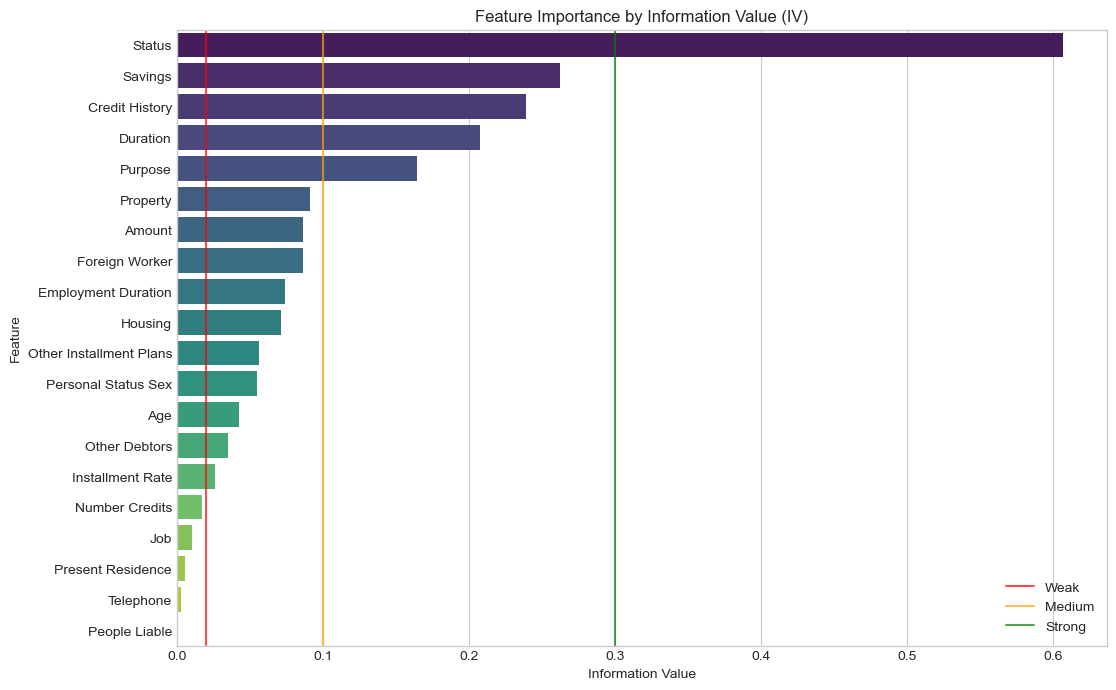


📝 Building Credit Scorecard...

Default Rates by Score Band:
Empty DataFrame
Columns: [Count, Default_Rate]
Index: []


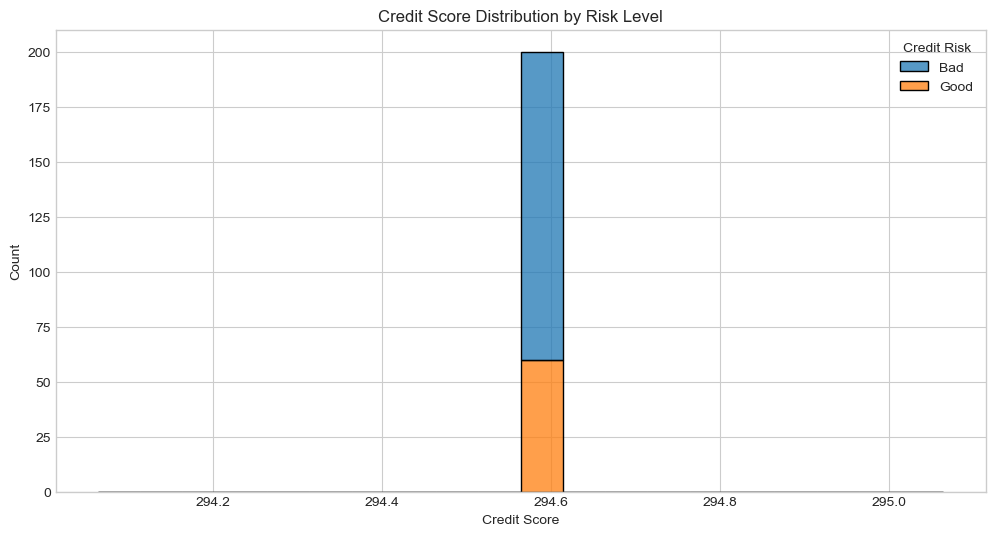


🏁 Final Credit Scorecard Summary:
Base Points: 318.37
Points to Double Odds (PDO): 50
AUC-ROC: 0.6739
KS Statistic: 30.71%


In [5]:
if __name__ == "__main__":
    # Initialize and run model
    scorecard_model = CreditScorecardModel()
    scorecard_model.load_data("german_credit_data.csv")
    scorecard_model.train_model()
    metrics = scorecard_model.evaluate()
    scorecard, base_points = scorecard_model.create_scorecard()
    
    # Print final summary
    print("\n🏁 Final Credit Scorecard Summary:")
    print(f"Base Points: {base_points:.2f}")
    print(f"Points to Double Odds (PDO): {scorecard_model.pdo}")
    print(f"AUC-ROC: {metrics['AUC-ROC']:.4f}")
    print(f"KS Statistic: {metrics['KS Statistic']:.2f}%")

### Credit Scorecard Summary

- Base Points: 318.37 – The baseline score assigned before adjustments for risk.
- Points to Double Odds (PDO): 50 – Each 50-point increase in score doubles the odds of good credit.
- AUC-ROC (0.6739) & KS (30.71%) – Moderate model performance, but room for improvement.

### Key Takeaways & Next Steps

- The model is highly sensitive to bad credit cases (high recall for bad credit) but performs poorly in detecting good credit (low recall for good credit).
- The scorecard's Default Rate bands were not computed, so you may need to check for missing values or scoring errors.
- The KS score and AUC suggest the model is somewhat useful, but not optimal.

### Recommendations to Improve the Model:

- Fix Default Rate Calculation – Check why the Default Rates by Score Band is empty. Ensure proper binning.
- Balance Performance Between Good & Bad Credit – Adjust the decision threshold to improve recall for good credit cases.
- Improve Feature Engineering – Add or refine features (e.g., WoE transformations, additional risk indicators).
- Try Alternative Models – Consider boosting models (e.g., XGBoost, LightGBM) or fine-tune logistic regression.

## Conclusion

The model was evaluated using AUC-ROC (0.6739), AUC-PR (0.8028), and KS Statistic (30.71%), indicating moderate discriminatory power. While the model effectively identified bad credit cases (high recall for defaulters), it struggled to detect good credit cases, suggesting room for improvement in balancing sensitivity and specificity.

Additionally, the credit scorecard framework was designed with base points (318.37) and points to double odds (PDO: 50), ensuring a structured approach to risk assessment. However, issues with default rate calculation in score bands highlighted areas for refinement in the binning process.

### Future Improvements

- Fine-tuning binning strategies to ensure accurate score band calculations.
- Improving feature selection by exploring additional financial indicators.
- Balancing recall between good and bad credit cases to reduce misclassification.
- Experimenting with alternative models like boosting algorithms for better predictive power.